In [53]:
!pip install imutils --quiet
!pip install efficientnet

In [54]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [55]:
from pathlib import Path

img_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
image_dir = Path(img_dir)
filepaths = list(image_dir.glob(r'**/*.png'))

labels = []
for filepath in filepaths:
    label = os.path.split(os.path.split(filepath)[0])[1]
    labels.append(label)

In [56]:
# filepaths

In [57]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac=1).reset_index(drop = True)

df.head(4)
df['Label'].value_counts()

Label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

In [58]:
import plotly.express as px

Class_series = pd.Series(df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

color_map = {
    'No_DR': 'orange',
    'Mild': 'navy',
    'Moderate': 'skyblue',
    'Severe': 'purple',
    'Proliferate_DR': 'black'
}

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_map=color_map,
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})  
fig.show()

In [59]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(df['Label'])
df['Label']=labelEncoder.transform(df['Label'])

In [60]:
from sklearn.utils import resample

n_samples = 400
label_counts = df['Label'].value_counts()
dfs_by_label_resampled = {}


for label in range(5):    
    if label_counts[label] < n_samples:
    
        df_label_resampled = pd.concat([df[df['Label'] == label]] * ((n_samples + label_counts[label] - 1) // label_counts[label]))
        df_label_resampled = df_label_resampled.sample(n_samples, replace=True, random_state=42)
    else:
        df_label_resampled = resample(df[df['Label'] == label], n_samples=n_samples, replace=True, random_state=42)
    
    dfs_by_label_resampled[label] = df_label_resampled

balanced_df = pd.concat(dfs_by_label_resampled.values())

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['Label'].value_counts()


Label
4    400
0    400
3    400
2    400
1    400
Name: count, dtype: int64

In [61]:
import plotly.express as px

# Assuming pandas is imported as pd and balanced_df is your DataFrame
Class_series = pd.Series(balanced_df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

# Define elite colors for each severity
color_map = {
    'No_DR': 'orange',
    'Mild': 'navy',
    'Moderate': 'skyblue',
    'Severe': 'purple',
    'Proliferate_DR': 'black'
}

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_map=color_map,
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})  
fig.show()


In [62]:
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2


directory = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'

pattern = os.path.join(directory, '*', '*.png')

image_paths = glob(pattern)

size = (224, 224)

def load_image_and_resize(filepath):
    img = Image.open(filepath)
    img = img.resize(size)
    img = np.asarray(img)
    return img

balanced_df['image'] = balanced_df['Filepath'].map(lambda x: load_image_and_resize(x))


In [63]:
balanced_df['image'].head()

0    [[[128, 128, 128], [131, 129, 128], [128, 128,...
1    [[[124, 128, 126], [128, 129, 129], [130, 131,...
2    [[[128, 128, 128], [123, 127, 127], [125, 128,...
3    [[[128, 128, 128], [128, 128, 128], [128, 128,...
4    [[[128, 124, 125], [128, 128, 128], [132, 128,...
Name: image, dtype: object

In [64]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
sampled_images =balanced_df['image'].sample(6, random_state=42)
size = (224, 224)
sampled_images = [Image.fromarray(img).resize(size) for img in sampled_images]

sampled_images = [np.array(img) for img in sampled_images]

fig = make_subplots(rows=2, cols=3, subplot_titles=("Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6"))

for i, img in enumerate(sampled_images, start=1):
    fig.add_trace(go.Image(z=img), row=(i-1) // 3 + 1, col=(i-1) % 3 + 1)

fig.update_layout(
    title="Sample Images",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)
fig.show()

In [65]:
from keras.utils import to_categorical
x=np.asarray(balanced_df['image'].to_list())
x=x/255
y=balanced_df['Label']
y=to_categorical(y,num_classes=5)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42,shuffle=True)

**Pretriend models**

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121,ResNet50,VGG16,InceptionV3,EfficientNetB0
from keras.callbacks import EarlyStopping


es = EarlyStopping(monitor='val_accuracy', min_delta = 0.005, patience=10, verbose=1, mode='auto')

VGG-16

In [67]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg16.trainable = False
x_vgg16 = Flatten()(vgg16.output)
x_vgg16 = Dense(256, activation='relu')(x_vgg16)
x_vgg16 = Dropout(0.4)(x_vgg16)
predictions_vgg16 = Dense(5, activation='softmax')(x_vgg16)
model_vgg16 = Model(inputs=vgg16.input, outputs=predictions_vgg16)
model_vgg16.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg16 = model_vgg16.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/100
  2/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.0469 - loss: 2.3705    

W0000 00:00:1714580297.886446     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3535 - loss: 1.6270

W0000 00:00:1714580305.908176     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.3541 - loss: 1.6249 - val_accuracy: 0.4350 - val_loss: 1.2695
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.4883 - loss: 1.2173 - val_accuracy: 0.5175 - val_loss: 1.1869
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5255 - loss: 1.1434 - val_accuracy: 0.5325 - val_loss: 1.1356
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.5354 - loss: 1.1175 - val_accuracy: 0.5550 - val_loss: 1.1070
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5346 - loss: 1.0680 - val_accuracy: 0.5675 - val_loss: 1.0505
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5475 - loss: 1.0697 - val_accuracy: 0.5775 - val_loss: 1.0397
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5705 - loss: 1.0125 - val_accuracy: 0.5675 - val_loss: 1.0479
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.5966 - loss: 0.9916 - val_accura

In [68]:
loss, accuracy = model_vgg16.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

 1/13 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - accuracy: 0.8125 - loss: 0.5305

W0000 00:00:1714581151.762394     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.7768 - loss: 0.7922
Test Loss: 0.7726274728775024
Test Accuracy: 0.7875000238418579


W0000 00:00:1714581153.756644     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


**ResNet50**

In [69]:
resnet50 = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
resnet50.trainable = False
x_resnet50 = Flatten()(resnet50.output)
x_resnet50 = Dense(256, activation='relu')(x_resnet50)
x_resnet50 = Dropout(0.4)(x_resnet50)
predictions_resnet50 = Dense(5, activation='softmax')(x_resnet50)
model_resnet50 = Model(inputs=resnet50.input, outputs=predictions_resnet50)
model_resnet50.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet50 = model_resnet50.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.2924 - loss: 1.8402 - val_accuracy: 0.3450 - val_loss: 1.3918
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3397 - loss: 1.4488 - val_accuracy: 0.3675 - val_loss: 1.3753
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3532 - loss: 1.3956 - val_accuracy: 0.3325 - val_loss: 1.3572
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3341 - loss: 1.3933 - val_accuracy: 0.3250 - val_loss: 1.3639
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3035 - loss: 1.4182 - val_accuracy: 0.3675 - val_loss: 1.3677
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3455 - loss: 1.3965 - val_accuracy: 0.3375 - val_loss: 1.3604
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3309 - loss: 1.3972 - val_accuracy: 0.3675 - val_loss: 1.3530
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3180 - loss: 1.4025 

In [70]:
loss, accuracy = model_resnet50.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.4690 - loss: 1.1845
Test Loss: 1.1874468326568604
Test Accuracy: 0.4749999940395355


**InceptionV3**

In [71]:
inceptionv3 = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
inceptionv3.trainable = False
x_inceptionv3 = Flatten()(inceptionv3.output)
x_inceptionv3 = Dense(128, activation='relu')(x_inceptionv3)
x_inceptionv3 = Dropout(0.33)(x_inceptionv3)
predictions_inceptionv3 = Dense(5, activation='softmax')(x_inceptionv3)
model_inceptionv3 = Model(inputs=inceptionv3.input, outputs=predictions_inceptionv3)
model_inceptionv3.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_inceptionv3 = model_inceptionv3.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.3850 - loss: 1.9215 - val_accuracy: 0.5350 - val_loss: 1.1203
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5677 - loss: 1.0368 - val_accuracy: 0.6075 - val_loss: 0.9942
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6819 - loss: 0.8350 - val_accuracy: 0.6925 - val_loss: 0.8893
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.6939 - loss: 0.7765 - val_accuracy: 0.7375 - val_loss: 0.8068
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7701 - loss: 0.6022 - val_accuracy: 0.7350 - val_loss: 0.7422
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8019 - loss: 0.5217 - val_accuracy: 0.7600 - val_loss: 0.7020
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8381 - loss: 0.4589 - val_accuracy: 0.7800 - val_loss: 0.6855
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8761 - loss: 0.3837 

In [72]:
loss, accuracy = model_inceptionv3.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.8125 - loss: 1.2809
Test Loss: 1.2253714799880981
Test Accuracy: 0.824999988079071


**EfficientnetB0**

In [73]:
efficientnetb0 = EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
efficientnetb0.trainable = False
x_efficientnetb0 = Flatten()(efficientnetb0.output)
x_efficientnetb0 = Dense(256, activation='relu')(x_efficientnetb0)
x_efficientnetb0 = Dropout(0.4)(x_efficientnetb0)
predictions_efficientnetb0 = Dense(5, activation='softmax')(x_efficientnetb0)
model_efficientnetb0 = Model(inputs=efficientnetb0.input, outputs=predictions_efficientnetb0)
model_efficientnetb0.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_efficientnetb0 = model_efficientnetb0.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/100
  5/100 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1727 - loss: 3.0295

W0000 00:00:1714582348.475356     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2002 - loss: 2.0718

W0000 00:00:1714582356.855028     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.2002 - loss: 2.0659 - val_accuracy: 0.1775 - val_loss: 1.6095
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1976 - loss: 1.6105 - val_accuracy: 0.1925 - val_loss: 1.6095
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1877 - loss: 1.6097 - val_accuracy: 0.1775 - val_loss: 1.6095
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2225 - loss: 1.6094 - val_accuracy: 0.1775 - val_loss: 1.6096
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2100 - loss: 1.6094 - val_accuracy: 0.1775 - val_loss: 1.6096
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1966 - loss: 1.6094 - val_accuracy: 0.1775 - val_loss: 1.6096
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1937 - loss: 1.6095 - val_accuracy: 0.1775 - val_loss: 1.6097
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1927 - loss: 1.6094 - val_accurac

In [74]:
loss, accuracy = model_efficientnetb0.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.1889 - loss: 1.6112
Test Loss: 1.6112395524978638
Test Accuracy: 0.17749999463558197


W0000 00:00:1714582689.859754     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Fusionnet

In [75]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.applications import MobileNetV2

densenet = DenseNet121(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
densenet.trainable = False

x_densenet = Flatten()(densenet.output)
x_densenet = Dense(256, activation='relu')(x_densenet)
x_densenet = Dropout(0.4)(x_densenet)

mobilenet = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
mobilenet.trainable = False

x_mobilenet = Flatten()(mobilenet.output)
x_mobilenet = Dense(256, activation='relu')(x_mobilenet)
x_mobilenet = Dropout(0.4)(x_mobilenet)

concatenated = Concatenate()([x_densenet, x_mobilenet])

prediction = Dense(5, activation='softmax')(concatenated)

FusionNet = Model(inputs=[densenet.input, mobilenet.input], outputs=prediction)

FusionNet.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fusionnet = FusionNet.fit([x_train, x_train], 
                             y_train, 
                             epochs=100, 
                             batch_size=16, 
                             validation_data=([x_test, x_test], y_test))


Epoch 1/100
  2/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.2500 - loss: 3.5170  

W0000 00:00:1714582726.923248     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4333 - loss: 2.5218

W0000 00:00:1714582746.430654     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 212ms/step - accuracy: 0.4340 - loss: 2.5139 - val_accuracy: 0.5850 - val_loss: 1.0825
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6532 - loss: 0.8859 - val_accuracy: 0.6350 - val_loss: 0.8784
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6934 - loss: 0.7561 - val_accuracy: 0.7375 - val_loss: 0.7822
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7648 - loss: 0.6066 - val_accuracy: 0.7550 - val_loss: 0.7109
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8336 - loss: 0.4649 - val_accuracy: 0.7500 - val_loss: 0.6557
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8490 - loss: 0.4057 - val_accuracy: 0.7675 - val_loss: 0.6566
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8608 - loss: 0.3834 - val_accuracy: 0.8175 - val_loss: 0.5819
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9048 - loss: 0.2925 - val_accura

In [76]:
loss, accuracy = FusionNet.evaluate([x_test, x_test], y_test)


# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 663ms/step - accuracy: 0.8458 - loss: 1.0487
Test Loss: 1.075734257698059
Test Accuracy: 0.8424999713897705


W0000 00:00:1714583576.870656     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [77]:
FusionNet.save("fusionnet_model.h5")

In [78]:
# import gradio as gr
# import numpy as np
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input

# # Function to preprocess the uploaded image
# def preprocess_image(img):
#     # Convert Gradio Image to numpy array
#     img = img.astype('uint8')
#     # Convert to uint8 for compatibility with Keras preprocessing
#     img = tf.image.resize(img, (224, 224))
#     img = image.array_to_img(img)
#     # Preprocess the image for MobileNetV2
#     img_mobilenet = preprocess_input(np.expand_dims(img, axis=0))
#     # Preprocess the image for DenseNet121
#     img_densenet = densenet_preprocess_input(np.expand_dims(img, axis=0))
#     return [img_densenet, img_mobilenet]

# # Function to make predictions using the FusionNet model
# def predict_image(img):
#     preprocessed_img = preprocess_image(img)
#     predictions = FusionNet.predict(preprocessed_img)
#     predicted_class = np.argmax(predictions[0])
#     class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
#     return class_names[predicted_class]

# # Define the Gradio interface
# input_image = gr.Image(height = 224 ,width = 224)
# output_text = gr.Textbox(label="Predicted Class")


In [79]:
# # Launch the Gradio interface
# gr.Interface(fn=predict_image, inputs=input_image, outputs=output_text).launch()

In [80]:
# from tensorflow.keras.preprocessing import image
# import numpy as np

# def preprocess_image(image_path):
#     img = image.load_img(image_path, target_size=(224, 224))
#     img_array = image.img_to_array(img)
#     img_array=img_array/255
#     img_array = np.expand_dims(img_array, axis=0)
#     return img_array

# image_path = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR/002c21358ce6.png'
# img_array = preprocess_image(image_path)
# predictions = FusionNet.predict([img_array, img_array])
# predicted_class = np.argmax(predictions[0])


In [81]:
# class_names = {
#     0: "Mild",
#     1: "Moderate",
#     2: "No DR",
#     3: "Proliferate",
#     4: "Severe"
# }
# predicted_class_name = class_names.get(predicted_class, "Unknown")

# print("Predicted class:", predicted_class_name)

In [82]:
# from matplotlib import pyplot as plt
# from matplotlib import image as mpimg

# image_path = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/001639a390f0.png'
# img = mpimg.imread(image_path)

# plt.imshow(img)
# plt.axis('off')  
# plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


W0000 00:00:1714583606.084770     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


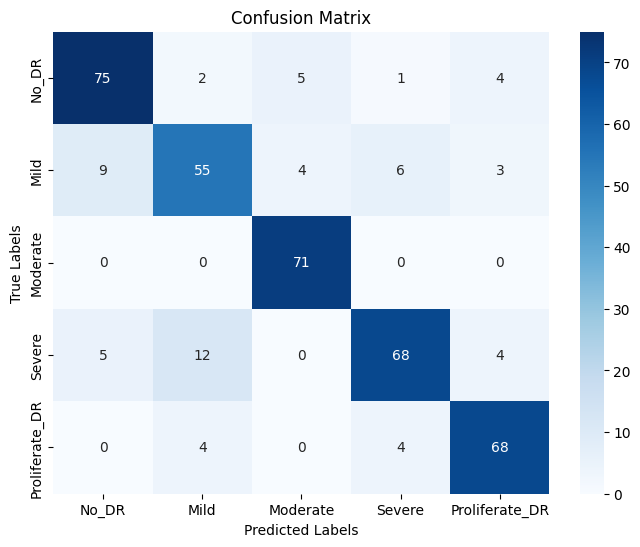

In [83]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = FusionNet.predict([x_test, x_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"],
            yticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion.png', bbox_inches='tight')
plt.show()


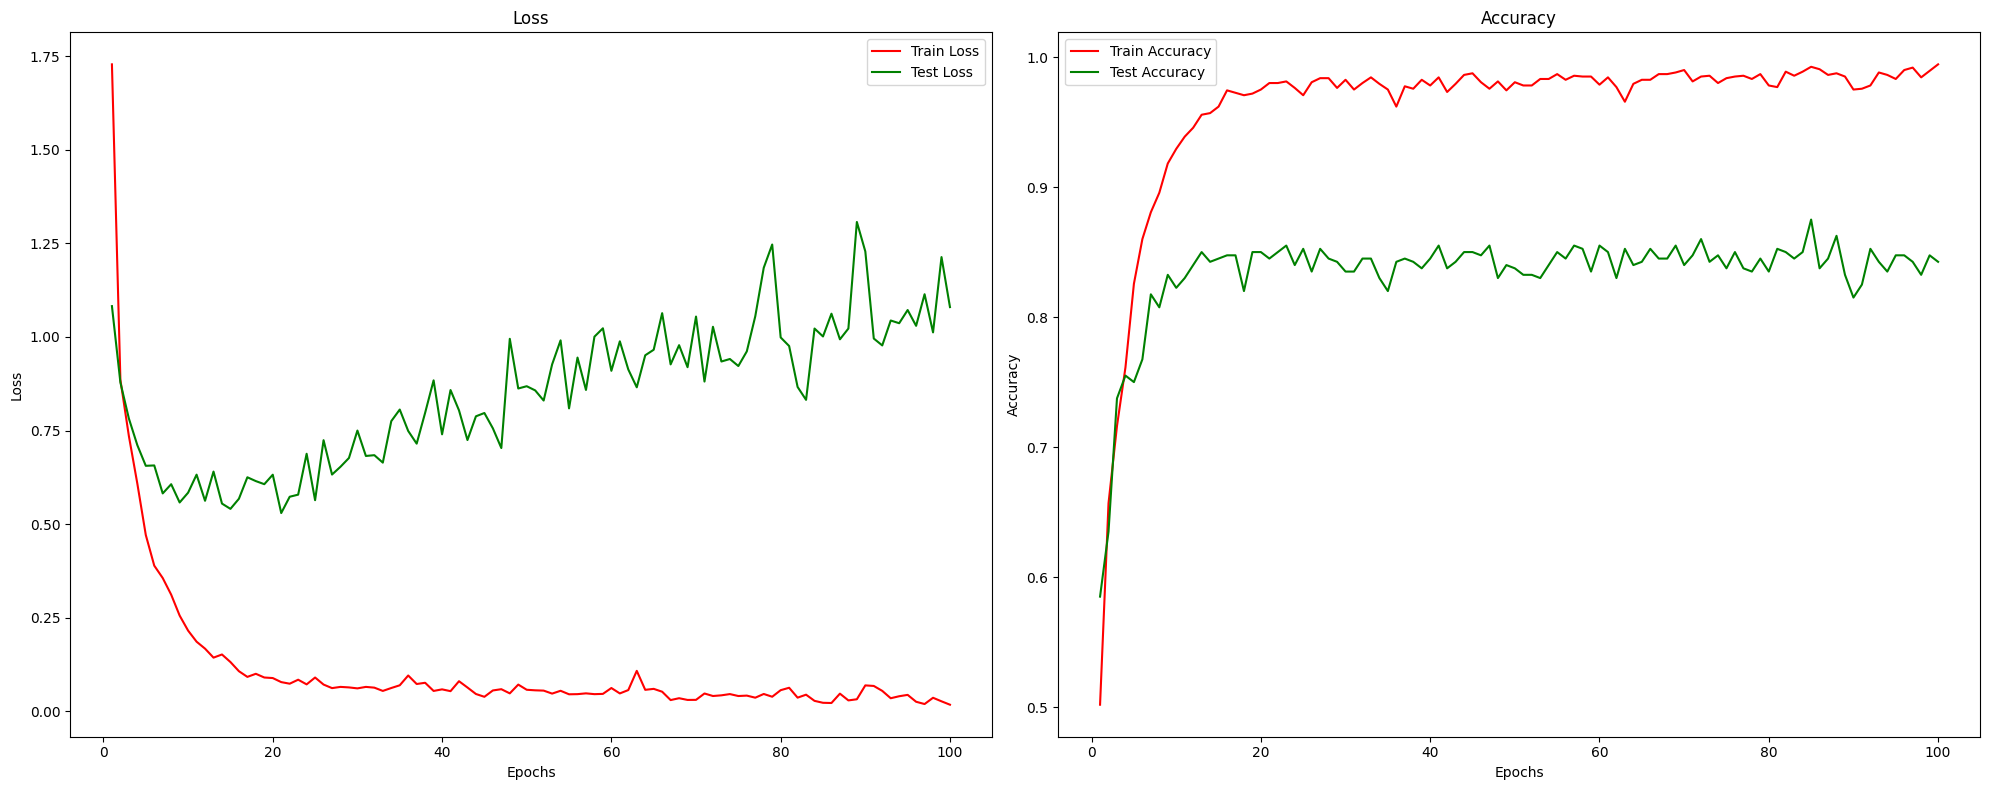

In [84]:
import matplotlib.pyplot as plt
tr_acc = history_fusionnet.history['accuracy']
tr_loss = history_fusionnet.history['loss']
val_acc = history_fusionnet.history['val_accuracy']
val_loss = history_fusionnet.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Test Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Test Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('accuracy and losses.png', bbox_inches='tight')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


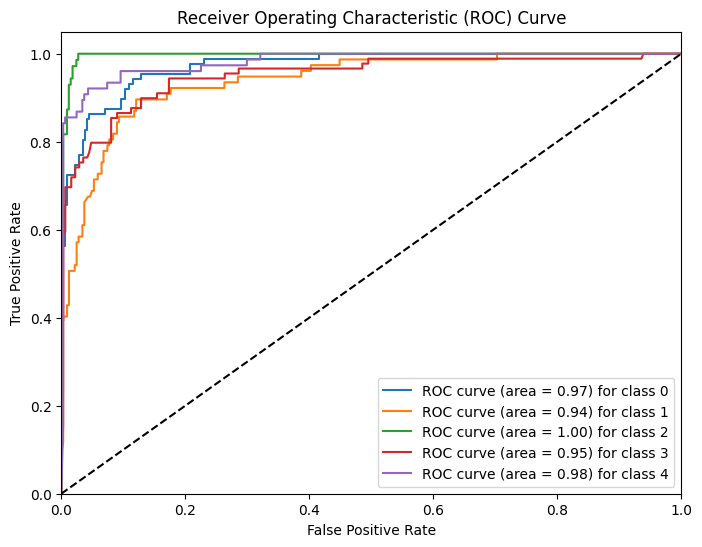

In [85]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions using the FusionNet model
y_pred_proba = FusionNet.predict([x_test, x_test])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):  # Assuming you have 5 classes
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('Roc.png', bbox_inches='tight')
plt.show()


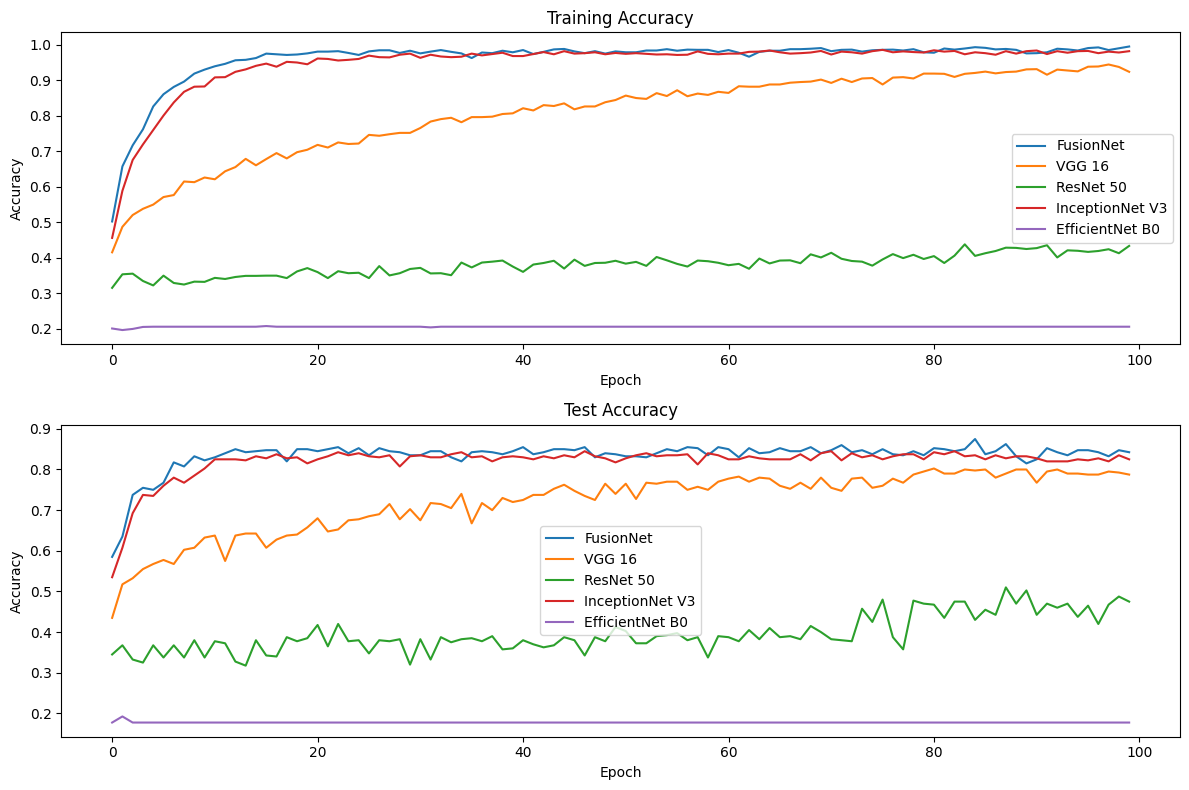

In [86]:
import matplotlib.pyplot as plt

histories = [history_fusionnet, history_vgg16,history_resnet50,history_inceptionv3,history_efficientnetb0]  # Replace with your actual histories

plt.figure(figsize=(12, 8))
models = ['FusionNet','VGG 16','ResNet 50','InceptionNet V3','EfficientNet B0']

plt.subplot(2, 1, 1)
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{models[i]}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=f'{models[i]}')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Model Comparison.png', bbox_inches='tight')
plt.show()


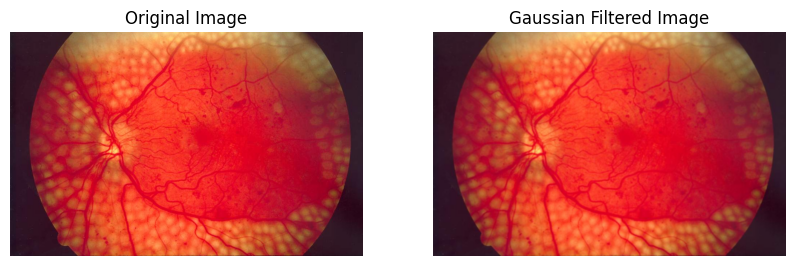

In [87]:
import cv2
import matplotlib.pyplot as plt

def gaussian_filtered_image(input_image_path, kernel_size=(5, 5), sigma_x=0):
    
    image = cv2.imread(input_image_path)
    
   
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma_x)
    
    return image, blurred_image


input_image_path = '/kaggle/input/forhad1/DR1.jpeg'
original_image, gaussian_image = gaussian_filtered_image(input_image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gaussian_image, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Filtered Image')
plt.axis('off')

plt.show()

In [88]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def custom_model(input_shape, num_classes):
#     inputs = tf.keras.Input(shape=input_shape)

#     x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
#     x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

#     x1 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x)
#     x1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x1)
#     x = layers.Concatenate()([x, x1])

#     x2 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x)
#     x2 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x2)
#     x = layers.Concatenate()([x, x2])

#     x3 = layers.Conv2D(128, kernel_size=(1, 1), padding='same', activation='relu')(x)
#     x3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x3)
#     x = layers.Concatenate()([x, x3])

#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model

In [89]:

# input_shape = (224, 224, 3)
# num_classes = 5

# custom_model = custom_model(input_shape, num_classes)

# custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])


# custom_model.summary()

In [90]:

# epochs = 40
# batch_size = 8

# history = custom_model.fit(x_train, y_train, 
#                            epochs=epochs, 
#                            batch_size=batch_size, 
#                            validation_data=(x_test, y_test))

# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

# for epoch in range(epochs):
#     print(f"Epoch {epoch + 1}: Train Accuracy = {train_accuracy[epoch]}, Validation Accuracy = {val_accuracy[epoch]}")
